## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [55]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau

from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [56]:
import platform

if torch.cuda.is_available():
    print("The code will run on GPU.")
    device = torch.device('cuda')
elif platform.system() == 'Darwin':
    # For Mac, check for MPS (Apple Silicon GPU support)
    if torch.backends.mps.is_available():
        print("The code will run on Apple Silicon GPU (MPS).")
        device = torch.device('mps')
    else:
        print("The code will run on CPU. MPS not available.")
        device = torch.device('cpu')
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
    device = torch.device('cpu')

The code will run on Apple Silicon GPU (MPS).


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [57]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [58]:
size = 128
transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor()
])

full_train = Hotdog_NotHotdog(train=True, transform=transform)

train_size = int(0.8 * len(full_train))
val_size   = len(full_train) - train_size
trainset, valset = random_split(full_train, [train_size, val_size])
testset = Hotdog_NotHotdog(train=False, transform=transform)

batch_size = 64
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(valset,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(testset,  batch_size=batch_size, shuffle=False, num_workers=0)

Let's look at some images from our data 

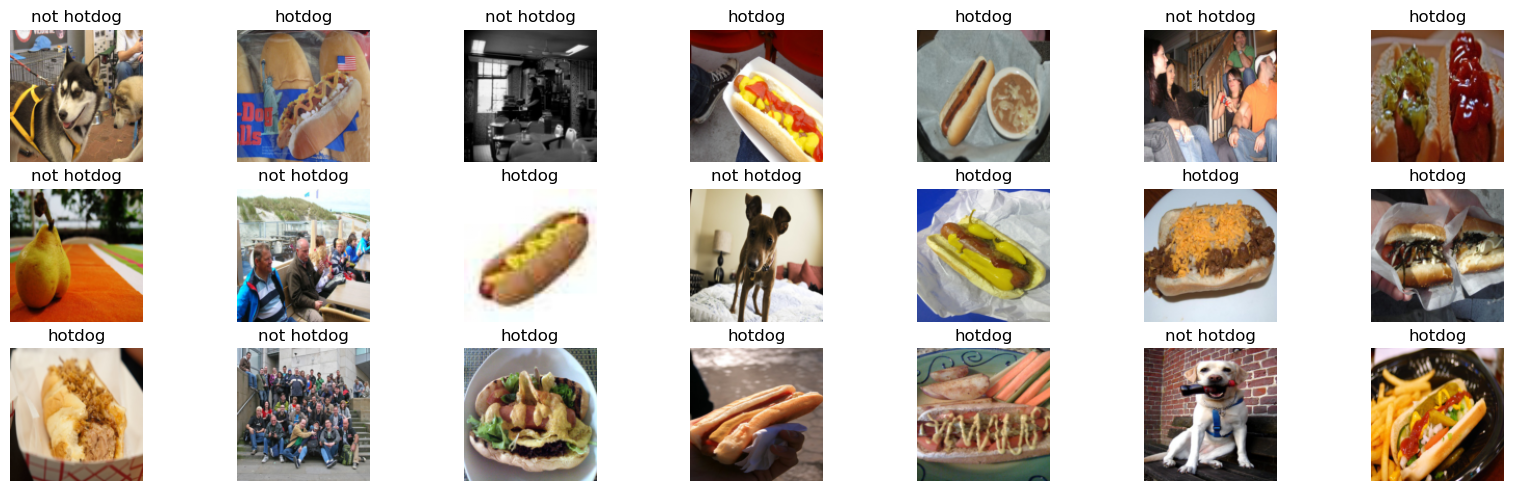

In [59]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [60]:
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 1)

freeze_backbone = False
for p in model.features.parameters():
    p.requires_grad = not freeze_backbone

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(
    (p for p in model.parameters() if p.requires_grad),
    lr=1e-3, weight_decay=1e-4
)

train_transforms = weights.transforms(antialias=True)
val_transforms   = weights.transforms(antialias=True)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"EfficientNet-B0 ready. Trainable params: {trainable_params:,} / {total_params:,}")

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',       # we want to reduce LR when val_loss stops decreasing
    factor=0.5,       # halve the LR
    patience=2,       # wait for 2 epochs with no improvement
    min_lr=1e-6,
    verbose=True
)

EfficientNet-B0 ready. Trainable params: 4,008,829 / 4,008,829


/Users/boldizsarhorvath/miniconda3/envs/ComputerVision/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Cycle

In [61]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        # labels: (batch,) -> (batch,1) for BCEWithLogitsLoss

        optimizer.zero_grad()
        outputs = model(images)  # (batch,1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels.int()).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


num_epochs = 100
best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "efficientnet_hotdog.pth")
        print("  -> Best model saved!")

    scheduler.step(epoch)

Epoch 1/100
  Train Loss: 0.3036 | Train Acc: 0.8705
  Val   Loss: 0.2758 | Val   Acc: 0.9146
  -> Best model saved!
Epoch 2/100
  Train Loss: 0.0962 | Train Acc: 0.9682
  Val   Loss: 0.2332 | Val   Acc: 0.9293
  -> Best model saved!
Epoch 3/100
  Train Loss: 0.0647 | Train Acc: 0.9798
  Val   Loss: 0.2737 | Val   Acc: 0.9341
  -> Best model saved!
Epoch 4/100
  Train Loss: 0.0518 | Train Acc: 0.9847
  Val   Loss: 0.1978 | Val   Acc: 0.9463
  -> Best model saved!
Epoch 5/100
  Train Loss: 0.0297 | Train Acc: 0.9921
  Val   Loss: 0.2451 | Val   Acc: 0.9244
Epoch 6/100
  Train Loss: 0.0110 | Train Acc: 0.9951
  Val   Loss: 0.1801 | Val   Acc: 0.9415
Epoch 7/100
  Train Loss: 0.0068 | Train Acc: 0.9982
  Val   Loss: 0.2016 | Val   Acc: 0.9488
  -> Best model saved!
Epoch 8/100
  Train Loss: 0.0022 | Train Acc: 1.0000
  Val   Loss: 0.1837 | Val   Acc: 0.9463
Epoch 9/100
  Train Loss: 0.0030 | Train Acc: 0.9994
  Val   Loss: 0.1922 | Val   Acc: 0.9439
Epoch 10/100
  Train Loss: 0.0081 | Tra

KeyboardInterrupt: 

Evaluate on test set

In [62]:
# Load best weights (saved when val_acc improved)
ckpt_path = "efficientnet_hotdog.pth"
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.to(device)

# Final evaluation on the held-out test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\n[TEST] Loss: {test_loss:.4f} | Acc: {test_acc:.4f} ({100*test_acc:.2f}%)")

# Confusion matrix (for 0/1 labels) with single-logit model


model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        preds = (torch.sigmoid(logits) > 0.5).long().cpu().numpy().ravel()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy().ravel())

print("\nClassification report:\n", classification_report(all_labels, all_preds, digits=4))

/var/folders/1b/r7r3wvt52kj74r354v00vqn40000gn/T/ipykernel_22283/1293144064.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, m


[TEST] Loss: 0.3138 | Acc: 0.9264 (92.64%)

Confusion matrix:
 [[827  68]
 [ 69 898]]

Classification report:
               precision    recall  f1-score   support

           0     0.9230    0.9240    0.9235       895
           1     0.9296    0.9286    0.9291       967

    accuracy                         0.9264      1862
   macro avg     0.9263    0.9263    0.9263      1862
weighted avg     0.9264    0.9264    0.9264      1862

